# Tutorial on DoWhy/EconML

In [ ]:
# Install package
!pip install dowhy
!pip install econml


     |████████████████████████████████| 164 kB 15.7 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0
     |████████████████████████████████| 3.3 MB 7.6 MB/s 
     |████████████████████████████████| 77 kB 4.2 MB/s 
     |████████████████████████████████| 356 kB 11.0 MB/s 
     |████████████████████████████████| 123 kB 52.7 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491665 sha256=2d868edb4b4f13ff79944b4872a68cb049d13bb824381b56b2af97ea97fddffc
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
  Attempting uninstall: dowhy
    Found existing installation: dowhy 0.7.1
    Uninstalling dowhy-0.7.1:
      Successfully uninstalled dowhy-0.7.1


In [ ]:
import warnings
warnings.filterwarnings('ignore')

from dowhy import CausalModel
from dowhy import datasets
import econml # Needed for Double ML

import networkx as nx
import matplotlib.pyplot as plt

# Tutorial on Causal Inference with DoWhy

This tutorial illustrates causal inference with the DoWhy library. It assumes you understand ideas like the causal directed acyclic graph, d-separation, as well as causal queries and estimands. To learn more about these ideas, consider taking the free [Causal Generative Modeling Minicourse](https://altdeep.teachable.com/p/causal-ml-minicourse).

DoWhy is a library in active development. The goal is to provide users with end-to-end causal data science and causal ML without deep knowledge of formal causal inference theory or estimation methods. End-to-end causal DS and ML is a broad scope that includes causal discovery and advanced multi-world counterfactual reasoning. So this tutorial focuses on using DoWhy to estimate causal effects, which is the library's most popular use case.

## Refresher on ATEs and CATEs

Causal effects are also called average treatment effects (ATE) or conditional average treatment effects (CATE).  Let $v_i$ denote the $i^{\text{th}}$ cause of interest (DoWhy allows you to have multiple) and $y$ denote the effect of interest.  In causal "do" notation (where "do" refers to an intervention), the ATE is: $$\frac{dE(y|do(v_i=x))}{dx}$$  This expression is a function that varies in x, reflecting that a cause can have different impacts on an effect depending on the value of the cause.

However, it is common to look at binary causes, such as in an A/B test or an experiment with a treatment and control.  In that case, the causal effect is: 
$$E(y|\text{do}(v_i = 1))-E(y|\text{do}(v_i = 0))$$ where 1 or `True` represents the treatment and 0 or `False` represents the control.

The "heterogeneity" of treatment effects refers to how the magnitude of causal effects varies with subsets of the data. "Heterogeneous treatment effects" are typically addressed with CATEs; a CATE is just a ATE for a specific subset of the population you are modeling. When using probability models, we address heterogeneity by treating causal effects as random variables and model their probability distributions; we model a CATE by conditioning that variable on other variables.  Suppose, for example, that the variable A stood for age, and the event A > 65 meant that age was greater than 65.  If you calculated the ATE for when CATE was greater than 65, you'd have a CATE: $$E(y|\text{do}(v_i = 1), A>65)-E(y|\text{do}(v_i = 0), A>65)$$

## Simulating data

I start by simulating data.  Simulating data is an excellent way to familiarize yourself with new algorithms because if there is an issue, you know it is not because of an artifact in the data.  In following code, I'll simulate a dataset with one cause or "treatment" variable, one effect or "outcome" variable, five common causes, two instruments, and one mediator or "front door."

I'll limit the dataset to only thirty samples.  A small dataset will give us a stronger impression of how various statistical methods for causal inference differ.  


In [ ]:
sim_data = datasets.linear_dataset(
    beta=10.0,
    num_treatments=1,
    num_instruments=2,
    num_common_causes=5,
    num_frontdoor_variables=1,
    num_samples=10000,
    treatment_is_binary=True,
    outcome_is_binary=False
)

In [ ]:
sim_data['gml_graph']

'graph[directed 1node[ id "y" label "y"]node[ id "Unobserved Confounders" label "Unobserved Confounders"]edge[source "Unobserved Confounders" target "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"] node[ id "W4" label "W4"]node[ id "Z0" label "Z0"] node[ id "Z1" label "Z1"]node[ id "FD0" label "FD0"]node[ id "v0" label "v0"]edge[source "Unobserved Confounders" target "v0"]edge[ source "W0" target "v0"] edge[ source "W1" target "v0"] edge[ source "W2" target "v0"] edge[ source "W3" target "v0"] edge[ source "W4" target "v0"]edge[ source "Z0" target "v0"] edge[ source "Z1" target "v0"]edge[ source "v0" target "FD0"]edge[ source "W0" target "y"] edge[ source "W1" target "y"] edge[ source "W2" target "y"] edge[ source "W3" target "y"] edge[ source "W4" target "y"]edge[ source "FD0" target "y"]edge[ source "W0" target "FD0"]edge[ source "W1" target "FD0"]edge[ source "W2" target "FD0"]edge[ source "W3" target "FD0"]edge[ source "W4"

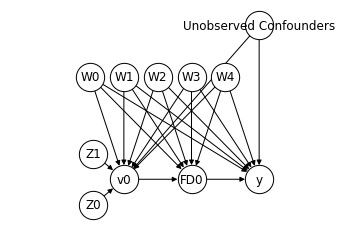

In [ ]:
G = nx.parse_gml(sim_data['gml_graph'])
pos = {'FD0': (300, 300),
 'Unobserved Confounders': (500, 600),
 'W0': (0, 500),
 'W1': (100, 500),
 'W2': (200, 500),
 'W3': (300, 500),
 'W4': (400, 500),
 'Z0': (10, 250),
 'Z1': (10, 350),
 'v0': (100, 300),
 'y': (500, 300)}
options = {
    "font_size": 12,
    "node_size": 800,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1,
}
nx.draw_networkx(G, pos, **options)
ax = plt.gca()
ax.margins(x=0.40)
plt.axis("off")
plt.show()

The argument `beta` is the coefficient multiplied against the causal treatment variable(s) in a linear model.  This argument can be a list or array with values corresponding to individual coefficients for multiple treatment variables.  In the case of a single float or int argument, the same `beta` is used for each treatment variable.

The return object is a dictionary.  One of the elements of the dictionary is a dataframe containing the simulated data.

In [ ]:
print("Causes (Treatments):", sim_data["treatment_name"])
print("Outcome:", sim_data["outcome_name"])
print("Instruments:", sim_data["instrument_names"])
print("Common Causes:", sim_data["common_causes_names"])
print("Mediators:", sim_data["frontdoor_variables_names"])

sim_data['df'][:5]

Causes (Treatments): ['v0']
Outcome: y
Instruments: ['Z0', 'Z1']
Common Causes: ['W0', 'W1', 'W2', 'W3', 'W4']
Mediators: ['FD0']


,FD0,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,-0.179452,0.0,0.624085,-0.582666,-0.362233,-0.995227,1.474667,2.778782,True,11.459168
1,-0.781266,0.0,0.947347,-0.839743,-0.973826,0.481474,0.080058,-1.825324,True,-13.715438
2,-0.177088,0.0,0.092040,-0.820287,-2.645051,-0.290554,-0.037053,-1.051341,False,-16.273311
3,0.077812,0.0,0.870281,-0.250943,0.028239,-0.165956,-0.428515,-1.145720,False,-6.427644
4,-2.959353,1.0,0.229241,-2.225829,-1.641042,1.440352,1.295065,-2.164781,False,-21.688041


The result also contains the graph in dot graph and GML graph formats.  The formats are convenient for exporting to other libraries.  For example, you could import the graph into networkx using `networkx.parse_gml`, where you could use networkx visualization tools, among other things.

However, it is more straightforward to visualize here by initializing DoWhy's  `CausalModel` object and using the `view_model` method.



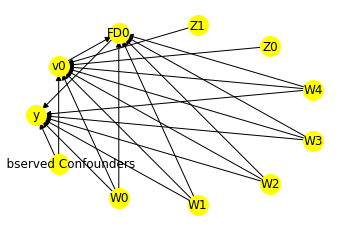

In [ ]:
model=CausalModel(
        data = sim_data['df'],
        treatment=sim_data['treatment_name'],
        outcome=sim_data['outcome_name'],
        graph=sim_data['gml_graph'],
        instruments=sim_data['instrument_names']
    )
model.view_model()

The simulated data also provides the ground truth ATE.  Our estimation techniques below will target this value.  We don't expect them to get the value exactly, but we do want the confidence intervals (when available) to include the value.  We also want the confidence intervals not to include 0, so we know there is enough precision in the estimate to distinguish it from 0.

In [ ]:
print("The ground truth causal effect is", sim_data["ate"])

The ground truth causal effect is 2.314207200894103


The constructor for the CausalModel class asks you for the causal DAG, the treatment and outcome of interest, as well as the names of the common causes and the instruments.

Note the node "unobserved confounders" is added.  This node is a stand-in for any unobserved confounders the modeler may not be aware of.

## Finding identified estimands

Statistical estimation theory is about estimating things from data.  The thing you want to estimate is called the "estimand," for example, the average height of all humans.  The algorithm that estimates the estimand from data is called an estimator.   For example, a possible estimator for the average human height estimand is a procedure that:

1.  Randomly selects one hundred humans
1.  Measures heights
1.  Calculates the average of those heights

For the causal effect $𝐸(𝑦|\text{do}(𝑣_0=1)) - 𝐸(𝑦|\text{do}(𝑣_0=0))$, we need estimands for the causal quantity $P(𝑦|\text{do}(𝑣_0))$.  A causal effect is identified when, given the DAG and the data, an estimand exists.  In this case, causal inference theory (do-calculus or potential outcomes) gives us three estimands for the above causal structure.

Two rely only on the DAG. The *backdoor estimand* is: $$P(y|do(v_o)) = \int_{W_0, ..., W_4} P(y|v_0, W_0, W_1, W_2, W_3, W_4)P(W_0, W_1,W_2, W_3, W_4)dw_1 dw_2 dw_3 dw_4$$ This is the estimand in the case when the W's are continuous, when they are discrete we sum instead of integration. That requires us to work with all of the common causes.  The ​front-door estimand avoids the common causes, working only with $FD_0$.  However, it is a bit more nuanced.  In the case of a binary $v_0$ and a continuous $FD_0$ is evaluates to: 
$$P(y|do(v_o))=E_{\text{FD}_0|v_0}{{ \left [ P(y \middle| v_o=1, \text{FD}_0)P(v_o=1)+ P(y \middle| v_o=0, \text{FD}_0 \right)P\left(v_o=0) \right ]}}$$

The instrumental variable estimand is nuanced as well, especially when the outcome $y$ is binary.  But nuanced or no, the `identify_effect` method of the CausalModel object will find and list any identified estimands.

In [ ]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W2,W3,W4,W1,W0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W3,W4,W1,W0,U) = P(y|v0,W2,W3,W4,W1,W0)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
Expectation(Derivative(y, [FD0])*Derivative([FD0], [v0]))
Estimand assumption 1, Full-mediation: FD0 intercepts (blocks) all directed paths from v0 to y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{v0} and U→{FD0} then P(FD0|v0,U) = P(FD0|v0)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{FD0} and U→y then P(y|FD0,

Notice that `identify_effect` also indicates the assumptions made by each estimand.  For example, the backdoor estimand assumes no unknown confounders.  Recall that the CausalModel constructor added a catch-all node for unknown confounders when it displayed the graph.  I forced the estimand identification to ignore those unknown confounders by setting the `proceed_when_unidentifiable` argument to True.  When I set it to false, the backdoor estimand is not returned as it is no longer identified.


In [ ]:
#print(model.identify_effect(proceed_when_unidentifiable=False))


## Estimation methods for the estimands

Next, given these three estimands, we look at different estimators in DoWhy: linear regression, propensity score methods, instrumental variable estimation, and double machine learning.



### Linear Regression 

Linear regression estimation uses linear regression coefficient estimates to target the backdoor estimand.  The approach fits a linear regression model on the treatment(s) and the common causes.  

As I mentioned in the section "Refresher on ATE and CATE," the causal effect is defined as $\frac{dE(y|do(v_o=x))}{dx}$.  With linear regression modeling, we assume $y$ is a linear function of the treatment variable $v_0$ and the common causes.  The linear assumption means that the derivative evaluates to a constant, namely the coefficient for $v_0$.  Thus the estimand is the coefficient, and the estimator is the estimated coefficient from fitting a linear regression model.  This simplification means we don't need to integrate over the W's.  When the treatment variable is binary, the estimate is the coefficient estimate for when $v_0 = 1$. 


In [ ]:
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        confidence_intervals=True)

print(causal_estimate_reg)
print("The causal effect estimate is " + str(round(causal_estimate_reg.value, 4)))
print("The ground truth causal effect is", sim_data["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W2,W3,W4,W1,W0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W3,W4,W1,W0,U) = P(y|v0,W2,W3,W4,W1,W0)

## Realized estimand
b: y~v0+W2+W3+W4+W1+W0
Target units: ate

## Estimate
Mean value: 2.352412159044113
95.0% confidence interval: [[2.20448858 2.50033573]]

The causal effect estimate is 2.3524
The ground truth causal effect is 2.314207200894103


The "Causal Estimate" is the estimated coefficient for the treatment variable $v_0$.  The p-value is the significance test statistic for the null hypothesis that the true value of the coefficient is 0.  

Note that once we have established that we want to use regression as the estimation method, all of the model evaluation methods for regression become relevant.  For example, if there were issues with the fit, such as residuals that had unstable variance or correlated with regression variables, it should cause us to question the linear assumption.  We also care about sparsity.  In this case, we had 30 data points to calculate seven coefficient estimates (one for the $v_0$, one each for the common cause confounders $W$'s and an intercept term.  If there were more potential common causes, we might need more data for this method to work. 

## Propensity Score Methods

In our data, we have five common causes.  It is not uncommon to have many more.  Suppose instead of five there were $p$ common cause confounders.  The backdoor estimand requires a statistical method that effectively integrates over (or sums over) the W's.  These W's could be many.  Continuous W's would require numeric integration, discrete W's might still be challenging if they have many levels.  In modern machine learning contexts, the W's could be multidimensional variables.

We can think of a propensity score as a numeric value acts as a kind of stand-in for all the common causes.  When we estimate the backdoor estimand, we work with the propensity score because it's typically more tractable than working with all the W's directly.

When the treatment variable $v_0$ is binary, the propensity score is usually the likelihood a given observation would have a treatment value $v_0 = 1$ (regardless of what value it actually had).  That likelihood could be calculated using logistic regression or some classifier that modeled $P(v_0 = 1 | W_1, ...,W_p)$.  More generally, a propensity score just needs to renders $v_0$ conditionally independent of $W_1, ..., W_p$ (or close too it), so that the score is an effective proxy for those variables.

The main three propensity score methods are *propensity score stratification*, *propensity score matching* and *propensity score weighting*.  At a high level, these methods all try to do the same thing; use the propensity score to adjust for the common cause confounders $W_1, ..., W_p$.  They do so in different ways, with different trade-offs.

*Propensity score stratification* tries to adjust breaking the data up into subsets ("strata") according to propensity scores and taking the weighted average estimate of $P(y|v_o)$ over each subset (the weight is the subset size).  

*Propensity score matching* tries to match datapoints where $v_0 = 1$ to the closest datapoint where $v_0 = 0$ by propensity score then comparing matched pairs. 

*Propensity score weighting* methods use the propensity score as a weight in class of statistical estimation procedures called [inverse probability weighting](https://en.wikipedia.org/wiki/Inverse_probability_weighting).  

Use of propensity score procedures vary with the domain and the size of the data.  For example, propensity score stratification can break down when the data is too small because some subsets may be empty.  It also varies with who is doing the modeling, for examnple one method might be more popular with economists trained on certain textbooks, working on certain problems and writing for different paper reviewers and audiences than experts from other domains and backgrounds.

In [ ]:
causal_estimate_strat = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="ate",
                                              confidence_intervals=True)
print(causal_estimate_strat)
print("The causal effect estimate is " + str(round(causal_estimate_strat.value, 4)))
print("The ground truth causal effect is", sim_data["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W2,W3,W4,W1,W0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W3,W4,W1,W0,U) = P(y|v0,W2,W3,W4,W1,W0)

## Realized estimand
b: y~v0+W2+W3+W4+W1+W0
Target units: ate

## Estimate
Mean value: 2.3298410233143003
95.0% confidence interval: (2.2150479416434483, 2.51026703501038)

The causal effect estimate is 2.3298
The ground truth causal effect is 2.314207200894103


In [ ]:
causal_estimate_match = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching",
                                              target_units="ate",
                                              confidence_intervals=True)
print(causal_estimate_match)
print("The causal effect estimate is " + str(round(causal_estimate_match.value, 4)))
print("The ground truth causal effect is", sim_data["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W2,W3,W4,W1,W0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W3,W4,W1,W0,U) = P(y|v0,W2,W3,W4,W1,W0)

## Realized estimand
b: y~v0+W2+W3+W4+W1+W0
Target units: ate

## Estimate
Mean value: 2.548527101776334
95.0% confidence interval: (2.340631327509362, 3.210107272612913)

The causal effect estimate is 2.5485
The ground truth causal effect is 2.314207200894103


For inverse probability score weighting, DoWhy supports [a few different weighting schemes](https://microsoft.github.io/dowhy/dowhy.causal_estimators.html#module-dowhy.causal_estimators.propensity_score_weighting_estimator
):
1. Vanilla Inverse Propensity Score weighting (IPS) (`weighting_scheme="ips_weight"`)
2. Self-normalized IPS weighting (also known as the Hajek estimator) (`weighting_scheme="ips_normalized_weight"`)
3. Stabilized IPS weighting (`weighting_scheme = "ips_stabilized_weight"`)


In [ ]:
causal_estimate_ipw = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_weight"},
                                            confidence_intervals=True)
print(causal_estimate_ipw)
print("The causal effect estimate is " + str(round(causal_estimate_ipw.value, 4)))
print("The ground truth causal effect is", sim_data["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W2,W3,W4,W1,W0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W3,W4,W1,W0,U) = P(y|v0,W2,W3,W4,W1,W0)

## Realized estimand
b: y~v0+W2+W3+W4+W1+W0
Target units: ate

## Estimate
Mean value: 3.0901441627897706
95.0% confidence interval: (2.7912324019624783, 3.423442266980829)

The causal effect estimate is 3.0901
The ground truth causal effect is 2.314207200894103


## Instrumental variable estimation and regression discontinuity

Instrumental variable (IV) estimation uses the instrument $Z_0$ to estimate an estimand that doesn't depend on any of the common causes in the estimation.  Whether or not IV estimation is possible depends on the causal DAG.  Like regression estimation, it relies on certain parametric assumptions as well.

In [ ]:
causal_estimate_iv = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable",
        method_params = {'iv_instrument_name': 'Z0'},
        confidence_intervals=True
)
print(causal_estimate_iv)
print("The causal effect estimate is " + str(round(causal_estimate_iv.value, 4)))
print("The ground truth causal effect is", sim_data["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                              -1
Expectation(Derivative(y, Z0))⋅Expectation(Derivative(v0, Z0))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['v0'] is affected in the same way by common causes of ['v0'] and y
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome y is affected in the same way by common c

Regression discontinuity is an estimation method popular in econometrics.  Regression discontinuity tries to model the "do" intervention by finding a threshold that partitions the data into two parts corresponding to two different "do" values (e.g., "treatment" and "control").  It compares observations lying closely on either side of the threshold because data points close to that threshold will have similar values for the confounders.

DoWhy treats it as a special type of [IV approach](https://microsoft.github.io/dowhy/dowhy.causal_estimators.html#dowhy.causal_estimators.regression_discontinuity_estimator.RegressionDiscontinuityEstimator
). The argument `rd_variable_name` name of the variable on where the thresholding occurs. This variable is analogous to the instrument.
`rd_threshold_value` is the threshold value where the split (or "discontinuity") occurs.  `rd_bandwidth` is the distance from the threshold within which confounders can be considered the same between treatment and control.



In [ ]:
%%capture
causal_estimate_regdist = model.estimate_effect(identified_estimand,
        method_name="iv.regression_discontinuity", 
        method_params={
            'rd_variable_name':'Z1',
            'rd_threshold_value':0.5,
            'rd_bandwidth': 0.15
        },
        confidence_intervals=True,
)

In [ ]:
print(causal_estimate_regdist)
print("The causal effect estimate is " + str(round(causal_estimate_regdist.value, 4)))
print("The ground truth causal effect is", sim_data["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
                                                                              
Expectation(Derivative(y, local_rd_variable))⋅Expectation(Derivative(v0, local

              -1
_rd_variable))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['local_treatment'] is affected in the same way by common causes of ['local_treatment'] and local_outcome
Estimand as

## Double-ML estimators using EconML

EconML is another Microsoft package for causal inference that focuses on *double machine learning estimators*.  Double machine learning is a method for estimating causal effects when there are many common causes or when a common cause is a high-dimensional vector.

The method reduces the problem to first estimating two predictive tasks:
* predicting the outcome from the common causes
* predicting the treatment from the common causes

Then the method combines these two predictive models in a final stage of causal effect estimation. Thus, the approach lets you use your preferred machine learning algorithm for the prediction tasks while maintaining favorable statistical properties related to the final estimate (e.g., precision, consistency, uncertainty quantification).


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

gb_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.DML",
    control_value = 0,
    treatment_value = 1,
    method_params={
        "init_params":{
            'model_y':GradientBoostingRegressor(),
            'model_t': GradientBoostingRegressor(),
            "model_final":LassoCV(fit_intercept=False),
            'featurizer':PolynomialFeatures(degree=1, include_bias=False)
        },
        "fit_params":{}
    }
)
print(gb_estimate)
print("The causal effect estimate is " + str(round(gb_estimate.value, 4)))
print("The ground truth causal effect is", sim_data["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W2,W3,W4,W1,W0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W3,W4,W1,W0,U) = P(y|v0,W2,W3,W4,W1,W0)

## Realized estimand
b: y~v0+W2+W3+W4+W1+W0 | 
Target units: ate

## Estimate
Mean value: 2.3816462056220895
Effect estimates: [2.38164621 2.38164621 2.38164621 ... 2.38164621 2.38164621 2.38164621]

The causal effect estimate is 2.3816
The ground truth causal effect is 2.314207200894103


The following code uses a similar approach called metalearning with a random forest predictor.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.metalearners.TLearner",
    method_params={
        "init_params": {'models': RandomForestRegressor()},
        "fit_params": {}
    }
)

print("The causal effect estimate is " + str(round(metalearner_estimate.value, 4)))
print("The ground truth causal effect is", sim_data["ate"])

The causal effect estimate is 4.7252
The ground truth causal effect is 2.314207200894103
